<a href="https://colab.research.google.com/github/Shiveringapple/DeepLearing/blob/main/transfer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import zipfile
z = zipfile.ZipFile("/content/drive/My Drive/train.zip ")
z.extractall("transfer")

In [ ]:
import glob
import pandas as pd
dogs = glob.glob("transfer/train/dog.*")
cats = glob.glob("transfer/train/cat.*")
df = pd.DataFrame({
    "path":dogs + cats,
    "ans":[0] * len(dogs) + [1] * len(cats)
})
df

,path,ans
0,transfer/train/dog.7074.jpg,0
1,transfer/train/dog.848.jpg,0
2,transfer/train/dog.11684.jpg,0
3,transfer/train/dog.6242.jpg,0
4,transfer/train/dog.1909.jpg,0
...,...,...
24995,transfer/train/cat.412.jpg,1
24996,transfer/train/cat.1407.jpg,1
24997,transfer/train/cat.7914.jpg,1
24998,transfer/train/cat.6850.jpg,1


In [ ]:
from tensorflow.keras.applications.vgg16 import VGG16
vgg = VGG16(include_top=False, input_shape=(224, 224, 3))
vgg.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

# Batch Normalization
## 1. 普通 ( standard )： 平均=0, 標準差=1
## 2. 最佳化：因應不同的batch，依據loss(負斜率)調整，將平均、標準差調成更好的區間(實驗科學)
### # 每一張圖都要算出普通平均、普通標準差、最佳化平均、最佳化標準差 -> 512*4=2048


In [ ]:
from tensorflow.keras.layers import Dense, Flatten, Dropout, BatchNormalization, GlobalAveragePooling2D
from tensorflow.keras.models import Sequential
mlp = [
    BatchNormalization(),
    GlobalAveragePooling2D(),
    Dense(2, activation="softmax")
]
for l in vgg.layers:
  l.trainable = False

layers = vgg.layers + mlp
model = Sequential(layers)
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
_________________________________________________________________
block3_conv1 (Conv2D)        (None, 56, 56, 256)      

In [ ]:
from tensorflow.keras.losses import SparseCategoricalCrossentropy
model.compile(loss=SparseCategoricalCrossentropy(),
       optimizer="adam",
       metrics=["accuracy"])

[[[  17.060997   -16.779       99.32     ]
  [  54.060997   -12.778999   117.32     ]
  [  72.061       -8.778999   103.32     ]
  ...
  [  76.061       34.221      -23.68     ]
  [  81.061       44.221      -14.68     ]
  [  78.061       51.221      -14.68     ]]

 [[  34.060997   -12.778999   121.32     ]
  [  56.060997   -19.779      119.32     ]
  [  76.061      -12.778999   105.32     ]
  ...
  [  82.061       42.221      -14.68     ]
  [  66.061       30.221      -24.68     ]
  [  63.060997    36.221      -28.68     ]]

 [[  44.060997   -38.779      131.32     ]
  [  76.061      -26.779      131.32     ]
  [ 108.061       -0.7789993  116.32     ]
  ...
  [  85.061       51.221       -0.6800003]
  [  39.060997     4.2210007  -44.68     ]
  [  58.060997    25.221      -29.68     ]]

 ...

 [[  93.061       21.221       64.32     ]
  [  90.061       23.221       53.32     ]
  [  93.061       31.221       52.32     ]
  ...
  [  12.060997   -64.779      -95.68     ]
  [  -9.939003   -

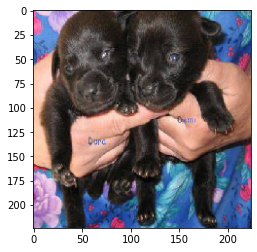

In [ ]:
# https://github.com/keras-team/keras-applications/blob/master/keras_applications/imagenet_utils.py
import matplotlib.pyplot as plt
import numpy as np
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.applications.vgg16 import preprocess_input

img = load_img(df["path"][0], target_size=(224, 224))
p = preprocess_input(np.array(img))
print(p)
plt.imshow(img)

In [ ]:
# 千萬別直接把df拿來train_test_split
# 只要開始資料處理，唯一認可numpy array
from sklearn.model_selection import train_test_split
x, y = np.array(df["path"]), np.array(df["ans"])
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.1)
print(x_train.shape, x_test.shape)

(22500,) (2500,)


In [ ]:
def getdata(x, y, batch=20):
    idx = np.random.randint(0, x.shape[0], size=batch)
    paths, ans = x[idx], y[idx]
    ori_imgs, pre_imgs = [], []
    for p in paths:
        img = load_img(p, target_size=(224, 224))
        img_np = np.array(img)
        ori_imgs.append(img_np)
        preprocess = preprocess_input(img_np)
        pre_imgs.append(preprocess)
    return (np.array(ori_imgs), np.array(pre_imgs), np.array(ans))

In [ ]:
for i in range(20):
    print("-" * 15, i, "-" * 15)
    ori, pre, ans = getdata(x_train, y_train)
    result = model.train_on_batch(pre, ans)
    print("[train]:", result)
    ori, pre, ans = getdata(x_test, y_test, 100)
    result = model.test_on_batch(pre, ans)
    print("[validate]:", result)

--------------- 0 ---------------
[train]: [0.15454766154289246, 0.9470587968826294]
[validate]: [0.1629187911748886, 0.9700000286102295]
--------------- 1 ---------------
[train]: [0.10575008392333984, 1.0]
[validate]: [0.10611080378293991, 0.9800000190734863]
--------------- 2 ---------------
[train]: [0.3140607476234436, 0.8500000238418579]
[validate]: [0.10708341002464294, 0.9800000190734863]
--------------- 3 ---------------
[train]: [0.2123904526233673, 0.949999988079071]
[validate]: [0.16580656170845032, 0.9599999785423279]
--------------- 4 ---------------
[train]: [0.29826241731643677, 0.8999999761581421]
[validate]: [0.2034348100423813, 0.949999988079071]
--------------- 5 ---------------
[train]: [0.19026479125022888, 0.949999988079071]
[validate]: [0.17988424003124237, 0.9100000262260437]
--------------- 6 ---------------
[train]: [0.28253626823425293, 0.800000011920929]
[validate]: [0.12357872724533081, 0.9800000190734863]
--------------- 7 ---------------
[train]: [0.1668

In [ ]:
# model.predict(pre)
ori, preprocess, ans = getdata(x_test, y_test, 1000)
model.evaluate(preprocess, ans)

32/32 [==============================] - 4s 118ms/step - loss: 0.1328 - accuracy: 0.9670


[0.13282378017902374, 0.9670000076293945]

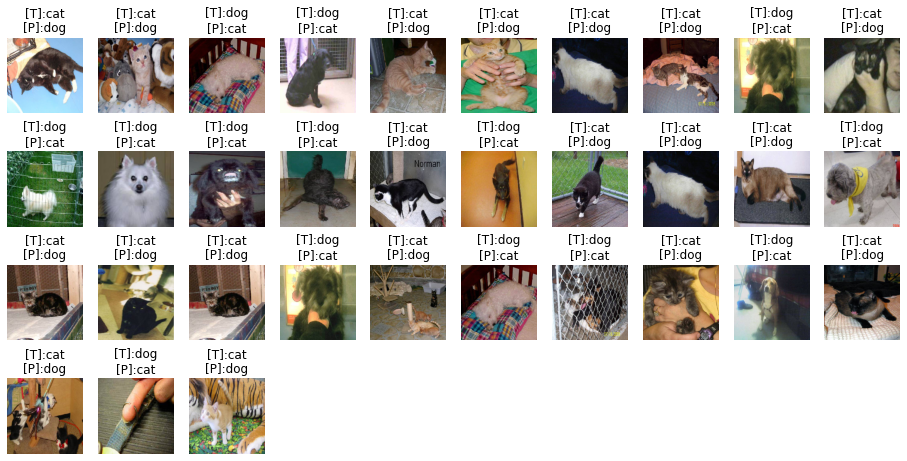

In [ ]:
import numpy as np
pre = model.predict_classes(preprocess)
idx = np.nonzero(pre != ans)[0]
idx = idx[:200]
img, label, pred = ori[idx], ans[idx], pre[idx]

trans = ["dog", "cat"]
plt.figure(figsize=(16, 8))
width = 10
height = len(img) // width + 1
for i in range(len(img)):
    plt.subplot(height, width, i+1)
    t = "[T]:{}\n[P]:{}".format(trans[label[i]], trans[pred[i]])
    plt.title(t)
    plt.axis("off")
    plt.imshow(img[i])